In [144]:
import os
if not os.path.exists("train.csv"):
  !wget --header="Host: datahack-prod.s3.amazonaws.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.89 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://datahack.analyticsvidhya.com/contest/janatahack-machine-learning-in-agriculture/" "https://datahack-prod.s3.amazonaws.com/train_file/train_yaOffsB.csv" -c -O 'train.csv'

if not os.path.exists("test.csv"):
  !wget --header="Host: datahack-prod.s3.amazonaws.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.89 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://datahack.analyticsvidhya.com/contest/janatahack-machine-learning-in-agriculture/" "https://datahack-prod.s3.amazonaws.com/test_file/test_pFkWwen.csv" -c -O 'test.csv'

In [145]:
import pandas as pd
import numpy as np
import seaborn as sns
import os

In [172]:
# ID	: UniqueID
# Estimated_Insects_Count	: Estimated insects count per square meter
# Crop_Type :	Category of Crop(0,1)
# Soil_Type	: Category of Soil (0,1)
# Pesticide_Use_Category : Type of pesticides uses (1- Never, 2-Previously Used, 3-Currently Using)
# Number_Doses_Week :	Number of doses per week
# Number_Weeks_Used	: Number of weeks used
# Number_Weeks_Quit	: Number of weeks quit
# Season :	Season Category (1,2,3)
# Crop_Damage	: Crop Damage Category (0=alive, 1=Damage due to other causes, 2=Damage due to Pesticides)

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
merge = pd.concat([train,test]).reset_index(drop=True)
print(merge.shape)

# test['Estimated_Insects_Count_per_km_sq'] = test['Estimated_Insects_Count'].apply(lambda x:x*0.000001) 
# train['Estimated_Insects_Count_per_km_sq'] = train['Estimated_Insects_Count'].apply(lambda x:x*0.000001) 

from sklearn.linear_model import LinearRegression,LogisticRegression
from lightgbm import LGBMRegressor,LGBMClassifier
from xgboost import XGBRegressor,XGBClassifier
from sklearn.model_selection import train_test_split

imputer = LGBMRegressor()
use_train = merge[~merge.Number_Weeks_Used.isna()]
X = use_train.drop(['ID','Number_Weeks_Used','Crop_Damage'],axis=1)
Y = use_train[['Number_Weeks_Used']]
impute_train_x,impute_test_x,impute_train_y,impute_test_y = train_test_split(X,Y,test_size=0.2,shuffle=True)
imputer.fit(impute_train_x,impute_train_y)
print(imputer.score(impute_test_x,impute_test_y))

imputer.fit(X,Y)

na_train = merge[merge.Number_Weeks_Used.isna()]
output = imputer.predict(na_train.drop(['ID','Number_Weeks_Used','Crop_Damage'],axis=1))
na_train['Number_Weeks_Used'] = output
print(na_train.shape,use_train.shape)

merge = pd.concat([use_train,na_train]).reset_index(drop=True)
print(merge.shape)

merge['Number_Weeks_Used'] = merge['Number_Weeks_Used'].apply(lambda x:int(x))

from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = MinMaxScaler(feature_range=(0,1))

num_cols= ['Estimated_Insects_Count','Number_Doses_Week','Number_Weeks_Used','Number_Weeks_Quit']
# for col in num_cols:
x = scaler.fit_transform(merge[num_cols])
merge.loc[:,num_cols] = x

  # break
  # print(x.shape,merge[col].shape)
  # merge[col] = 

drop_col = ['Crop_Type','Soil_Type','Season']

train = merge[~merge.Crop_Damage.isna()]
test = merge[merge.Crop_Damage.isna()].drop(['Crop_Damage'],axis=1)
# train
# train.drop(drop_col,inplace=True,axis=1)
# test.drop(drop_col,inplace=True,axis=1)


print(train.shape,test.shape)
# def factorize(column , df):
#   m = pd.get_dummies(df[column])
#   new_cols = []
#   for i in m.columns:
#     new_cols.append((i,f"{column}_{i}"))
#   m = m.rename(columns=dict(new_cols))
#   df = df.merge(m,left_index=True,right_index=True).drop([column],axis=1)
#   return df

# for col in ['Crop_Type','Soil_Type','Season','Pesticide_Use_Category']:
#   train = factorize(col,train)
# train

(148168, 10)
0.7248388153611619


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(14893, 10) (133275, 10)
(148168, 10)
(88858, 10) (59310, 9)


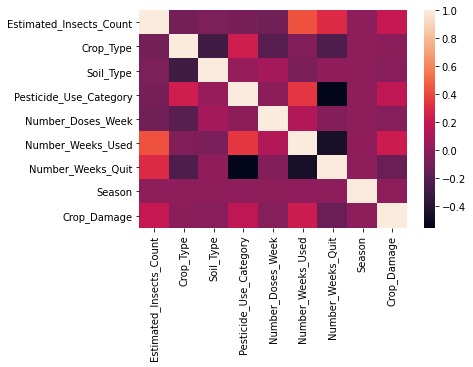

In [173]:
sns.heatmap(train.corr())

In [174]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88858 entries, 0 to 142274
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       88858 non-null  object 
 1   Estimated_Insects_Count  88858 non-null  float64
 2   Crop_Type                88858 non-null  int64  
 3   Soil_Type                88858 non-null  int64  
 4   Pesticide_Use_Category   88858 non-null  int64  
 5   Number_Doses_Week        88858 non-null  float64
 6   Number_Weeks_Used        88858 non-null  float64
 7   Number_Weeks_Quit        88858 non-null  float64
 8   Season                   88858 non-null  int64  
 9   Crop_Damage              88858 non-null  float64
dtypes: float64(5), int64(4), object(1)
memory usage: 7.5+ MB


In [175]:
# sns.distplot(train.Estimated_Insects_Count)
# sns.kdeplot(na_train.Number_Weeks_Used,label="imputed")
# sns.kdeplot(use_train.Number_Weeks_Used,label="before imputation")
# sns.kdeplot(merge.Number_Weeks_Used,label="after imputation")

In [176]:
# sns.distplot(train.Number_Weeks_Quit)

In [177]:
# sns.jointplot(x="Number_Weeks_Used",y="Number_Weeks_Quit",data=train,kind="kde")

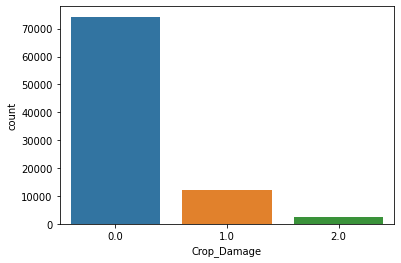

In [178]:
sns.countplot(train.Crop_Damage)

In [179]:
!pip install catboost

In [180]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split , KFold
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB,GaussianNB ,CategoricalNB
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier , AdaBoostClassifier

In [181]:
from sklearn.utils import class_weight
y = train[['Crop_Damage']].values.reshape((-1))
class_weights = class_weight.compute_class_weight('balanced',np.unique(y),y)
class_weights

array([ 0.39897806,  2.40670621, 12.80559158])

In [182]:
train_x,val_x = train_test_split(train,test_size=0.2,shuffle=True)

X = train.drop(['ID','Crop_Damage'],axis=1)
Y = train[['Crop_Damage']]

x_train = train_x.drop(['ID','Crop_Damage'],axis=1)
y_train = train_x[['Crop_Damage']]

x_val = val_x.drop(['ID','Crop_Damage'],axis=1)
y_val = val_x[['Crop_Damage']]

params={
    "od_type":"Iter",
    "od_wait":50,
    "learning_rate":0.15,
    "eval_metric":"Accuracy",
    "verbose":50,
    "boosting_type":"Plain",
    # "class_weights":class_weights
}

from sklearn.utils import class_weight
y = train[['Crop_Damage']].values.reshape((-1))
class_weights = class_weight.compute_class_weight('balanced',np.unique(y),y)
class_weights

# model= CatBoostClassifier(**params)
# model.fit(x_train,y_train,
#           # cat_features=["Crop_Type",'Soil_Type','Pesticide_Use_Category','Season'],
#           cat_features=['Pesticide_Use_Category'],
#           eval_set=(x_val,y_val))
# print("Catboost Score : ",model.score(x_val,y_val))

# model.fit(X,Y,
#           cat_features=["Crop_Type",'Soil_Type','Pesticide_Use_Category','Season'])

# for x_model in [LGBMClassifier(),XGBClassifier(),KNeighborsClassifier(n_neighbors=3),DecisionTreeClassifier(),RandomForestClassifier(),LogisticRegression()]:
#   x_model.fit(x_train,y_train,)
#   print(f"{str(x_model)[:15]} Score : ",x_model.score(x_val,y_val))
# from sklearn.neural_network import MLPClassifier

# mlp = MLPClassifier(hidden_layer_sizes=(150,64))
# mlp.fit(x_train,y_train)
# mlp.score(x_val,y_val)

array([ 0.39897806,  2.40670621, 12.80559158])

In [191]:
import warnings 
warnings.filterwarnings("ignore")

X = train.drop(['ID','Crop_Damage'],axis=1)
Y = train[['Crop_Damage']]

from sklearn.utils import class_weight
from sklearn.model_selection import KFold
y = train[['Crop_Damage']].values.reshape((-1))
class_weights = class_weight.compute_class_weight('balanced',np.unique(y),y)
class_weights

n_folds=[4,5,10]
for n_fold in n_folds:
  print("\nPerforming on N_folds :",n_fold)
  folds = KFold(n_splits=n_fold,shuffle=True)
  scores=[]
  max_score = 0

  for (train_idx,test_idx),i in list(zip(folds.split(X,Y),range(n_fold))):
    test_set = (X.iloc[test_idx],Y.iloc[test_idx])
    model = CatBoostClassifier(**params)
    model.fit(X.iloc[train_idx],Y.iloc[train_idx],
              cat_features=["Crop_Type",'Soil_Type','Pesticide_Use_Category','Season'],
              eval_set=test_set)
    # model= LGBMClassifier()
    # model.fit(X.iloc[train_idx],Y.iloc[train_idx])
    score = model.score(*test_set)
    scores.append(score)
    if score > max_score:
      max_score=score
      best_idx=train_idx
      val_idx = test_idx
    print("Catboost Score at fold %d : " % i,score)

  print("mean_score",np.array(scores).mean())
# model.fit(X,Y,
#           cat_features=["Crop_Type",'Soil_Type','Pesticide_Use_Category','Season'])


Performing on N_folds : 4
0:	learn: 0.8408385	test: 0.8389827	best: 0.8389827 (0)	total: 160ms	remaining: 2m 39s
50:	learn: 0.8452501	test: 0.8418186	best: 0.8418186 (50)	total: 6.37s	remaining: 1m 58s
100:	learn: 0.8476209	test: 0.8432591	best: 0.8432591 (82)	total: 12.5s	remaining: 1m 50s
150:	learn: 0.8490464	test: 0.8451047	best: 0.8451047 (150)	total: 18.9s	remaining: 1m 46s
200:	learn: 0.8505619	test: 0.8453297	best: 0.8455098 (173)	total: 25.3s	remaining: 1m 40s
250:	learn: 0.8514173	test: 0.8454648	best: 0.8456448 (234)	total: 31.9s	remaining: 1m 35s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8456448346
bestIteration = 234

Shrink model to first 235 iterations.
Catboost Score at fold 0 :  0.8456448345712356
0:	learn: 0.8405084	test: 0.8399730	best: 0.8399730 (0)	total: 133ms	remaining: 2m 12s
50:	learn: 0.8442597	test: 0.8443394	best: 0.8443394 (38)	total: 6.23s	remaining: 1m 55s
100:	learn: 0.8467356	test: 0.8468152	best: 0.8469052 (97)	total: 12.2s	r

In [195]:
n_folds=[]
for n_fold in n_folds:
  print("\nPerforming on N_folds :",n_fold)
  folds = KFold(n_splits=n_fold,shuffle=True)
  scores=[]
  max_score = 0

  for (train_idx,test_idx),i in list(zip(folds.split(X,Y),range(n_fold))):
    test_set = (X.iloc[test_idx],Y.iloc[test_idx])
    model = CatBoostClassifier(**params)
    model.fit(X.iloc[train_idx],Y.iloc[train_idx],
              cat_features=["Crop_Type",'Soil_Type','Pesticide_Use_Category','Season'],
              eval_set=test_set)
    # model= LGBMClassifier()
    # model.fit(X.iloc[train_idx],Y.iloc[train_idx])
    score = model.score(*test_set)
    scores.append(score)
    if score > max_score:
      max_score=score
      best_idx=train_idx
      val_idx = test_idx
    print("Catboost Score at fold %d : " % i,score)

  print("mean_score",np.array(scores).mean())


test_set = (X.iloc[val_idx],Y.iloc[val_idx])
model= CatBoostClassifier(**params)
model.fit(X.iloc[train_idx],Y.iloc[train_idx],
          cat_features=["Crop_Type",'Soil_Type','Pesticide_Use_Category','Season'],
          eval_set=test_set)
score = model.score(*test_set)
score

0:	learn: 0.8406462	test: 0.8444745	best: 0.8444745 (0)	total: 151ms	remaining: 2m 30s
50:	learn: 0.8443350	test: 0.8472879	best: 0.8472879 (45)	total: 6.99s	remaining: 2m 10s
100:	learn: 0.8468358	test: 0.8503264	best: 0.8503264 (98)	total: 14.3s	remaining: 2m 6s
150:	learn: 0.8486614	test: 0.8517893	best: 0.8517893 (129)	total: 21.9s	remaining: 2m 3s
200:	learn: 0.8500244	test: 0.8524646	best: 0.8525771 (167)	total: 29.5s	remaining: 1m 57s
250:	learn: 0.8508622	test: 0.8530272	best: 0.8532523 (249)	total: 37.1s	remaining: 1m 50s
300:	learn: 0.8515624	test: 0.8534774	best: 0.8539275 (280)	total: 44.8s	remaining: 1m 44s
350:	learn: 0.8522376	test: 0.8537025	best: 0.8540401 (308)	total: 52.3s	remaining: 1m 36s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.854040063
bestIteration = 308

Shrink model to first 309 iterations.


0.8540400630204816

In [196]:
pd.DataFrame(list(zip(x_train.columns,model.feature_importances_)),columns=['Feature','Importance']).sort_values("Importance",ascending=False)

,Feature,Importance
0,Estimated_Insects_Count,21.866511
5,Number_Weeks_Used,21.465803
4,Number_Doses_Week,19.807144
3,Pesticide_Use_Category,14.711503
6,Number_Weeks_Quit,10.784781
1,Crop_Type,4.658484
7,Season,3.898311
2,Soil_Type,2.807463


In [197]:
predictions = model.predict(test.drop(['ID'],axis=1))
test['Crop_Damage'] = predictions
submission = test[['ID','Crop_Damage']]
submission.to_csv("catboost_v3.csv",index=False)
submission

,ID,Crop_Damage
79858,F00000007,1.0
79859,F00000011,1.0
79860,F00000013,1.0
79861,F00000014,1.0
79862,F00000015,1.0
...,...,...
148163,F00155852,0.0
148164,F00155861,0.0
148165,F00155876,0.0
148166,F00155885,0.0
